# **Food Classification for Food101**

## **Comparing food classification models**

Before we chose our final model, we wanted to compare several food classification models to obtain a better sense of their respective perfomances. The models we chose are the following:
- ResNet-50
- MobileNetV2
- EfficientNetB0

We made our dataset smaller, as we discuss in the following sections, to test these models.

### **Import Packages**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset, DatasetDict, ClassLabel
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
import kagglehub
import random
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
import matplotlib.pyplot as plt

### **Load and Inspect Dataset**

We specifically used the Food101 dataset from Hugging Face. This dataset is already split and includes 75,750 images in training and 25,250 for testing. Each of the 101 classes has 750 training images and 250 testing images.

In [ ]:
ds = load_dataset("ethz/food101")
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

Here is an example image from the dataset:

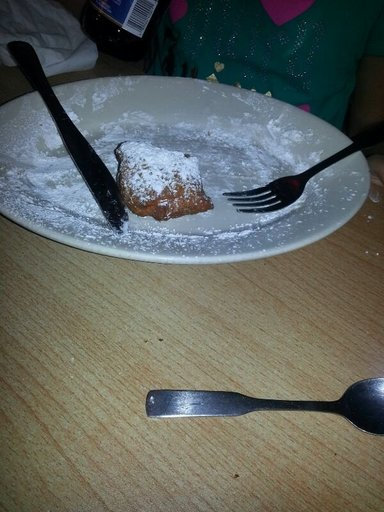

In [ ]:
ds["train"]["image"][0]

### **Make Dataset Smaller**

For initial comparison of the models, we wanted to use a smaller, more manageable dataset. We chose to consolidate our dataset below. We extracted 10 classes, each with 750 images in training data and 250 images in testing. We then took 10% of the training images for validation.

Note: We consulted AI tools to aid us with the syntax but the logic was based on our understanding of data splitting. We decided to use 10% of the training data as validation due to several online sources we consulted: https://kili-technology.com/blog/training-validation-and-test-sets-how-to-split-machine-learning-data

In [ ]:

#We kept the first 10 labels. We chose this so we didn't have to remap label ids in metadata
first_10_labels = list(range(10))

#Filter for only the desired labels
def filter_fn(example):
    return example["label"] in first_10_labels

#Apply filter to train and test
filtered_train = ds["train"].filter(filter_fn)
filtered_test = ds["validation"].filter(filter_fn)

#Split train into train + validation (10% for val).
#Additionally, stratify so the ratio of classes is the same in each split
split = filtered_train.train_test_split(test_size=0.1, stratify_by_column="label")

#Obtain the final val, test, and train sets
val_final = split["test"]
test_final = filtered_test
train_final = split["train"]

Filter:   0%|          | 0/75750 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Filter:   0%|          | 0/25250 [00:00<?, ? examples/s]

A list of the classes we are using.

In [ ]:
#Print the actual name
for i in first_10_labels:
    print(ds['train'].features['label'].int2str(i))

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


We are printing the datasets to make sure they were properly preprocessed.

In [ ]:
#Print the datasets to inspect
print(train_final)
print(val_final)
print(test_final)


Dataset({
    features: ['image', 'label'],
    num_rows: 6750
})
Dataset({
    features: ['image', 'label'],
    num_rows: 750
})
Dataset({
    features: ['image', 'label'],
    num_rows: 2500
})


### **Preprocess Dataset**

For the preprocessing stage, we consulted https://www.tensorflow.org/tutorials/load_data/images. We consulted exercise 4 from class. However, we did not preprocess with numpy arrays like we did in class because this proved to be computationally challenging with our dataset.

Preprocessing steps were as follows:
- Convert to RGB: We convert to RGB in order to have the right size for our images. We wanted 3 channels. Additionally, most CNNs use images in the RGB color space: https://www.sciopen.com/article/10.26599/TST.2024.9010001#:~:text=Although%20Convolutional%20Neural%20Networks%20(CNNs,most%20commonly%20used%20color%20spaces).
- Resize image: We resize the images to be 224 x 224 since this is the standard form most CNNs accept: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model/
- Preprocess image using the given model's preprocessing system: We used the preprocessing systems pertaining to each model.

Note: We consulted AI tools to aid with the syntax for the preprocessing code. However, we've commented the code below to explain our own logic for preprocessing.

In [ ]:
IMG_SIZE = 224

def preprocess(example):
    #Obtain the image from the example
    image = example["image"]
    #Convert to RGB so it has 3 dimensions
    image = image.convert('RGB')
    #Resize to be by 224 x 224 (eventually 224 x 224 x 3)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    #Obtain the image as a numpy array
    image = np.array(image)
    #Preprocess using the model's built-in preprocessing system
    image = tf.keras.applications.resnet50.preprocess_input(image.astype(np.float32))
    #Obtain the label for the image
    label = example["label"]
    return image, label

In [ ]:
#Used tf.data.Dataset from a generator to handle preprocessing for each of the
#images and then convert to correct output shape and type
#This source explains the generator: https://medium.com/the-owl/creating-a-tf-dataset-using-a-data-generator-5e5564609e64
train_tfds = tf.data.Dataset.from_generator(
    #We preprocess each part of the dataset
    lambda: (preprocess(x) for x in train_final),
    #The image itself is of type float and the label is of type int
    output_types=(tf.float32, tf.int64),
    #This corresponds to the 224 x 224 x 3 shape required for our model
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

val_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in val_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

test_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in test_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Print the dataset to ensure it is the correct shape and format:

In [ ]:
print(train_tfds)
print(val_tfds)
print(test_tfds)

<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


### **Plot the Preprocessed Image**

We plot the preprocessed image in a non-normalized form.

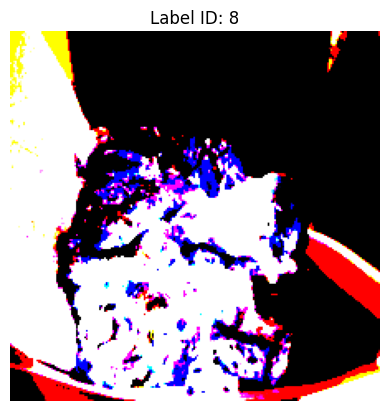

In [ ]:
#Separates the image and the label in the first part of the train_tfds dataset
img, label = next(iter(train_tfds))

#We normalized the image before, but now we undo that for plotting purposes
plt.imshow((img.numpy() + 1) / 2)
plt.title(f"Label ID: {label.numpy()}")
plt.axis("off")
plt.show()


### **Creating the ResNet-50 model**
We consulted GeeksForGeeks to get the exact pipeline: https://www.geeksforgeeks.org/computer-vision/image-classification-using-resnet/. We applied this pipeline to our other models.


In [ ]:
#Load the base model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Build the classification model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=[
        'accuracy',
    ]
)

In [ ]:
#Train the model
BATCH_SIZE = 64
history = model.fit(train_tfds.batch(BATCH_SIZE),
          epochs=10,
          validation_data=val_tfds.batch(BATCH_SIZE))

Epoch 1/10
    106/Unknown 71s 524ms/step - accuracy: 0.4919 - loss: 1.5055

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 662ms/step - accuracy: 0.4933 - loss: 1.5015 - val_accuracy: 0.7760 - val_loss: 0.6906
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 512ms/step - accuracy: 0.7950 - loss: 0.6397 - val_accuracy: 0.8067 - val_loss: 0.6098
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 514ms/step - accuracy: 0.8396 - loss: 0.4898 - val_accuracy: 0.8147 - val_loss: 0.5770
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 510ms/step - accuracy: 0.8765 - loss: 0.3942 - val_accuracy: 0.8080 - val_loss: 0.5615
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 519ms/step - accuracy: 0.9060 - loss: 0.3242 - val_accuracy: 0.8120 - val_loss: 0.5554
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 511ms/step - accuracy: 0.9293 - loss: 0.2705 - val_accuracy: 0.8040 - val_loss: 0.5544
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 520ms/step - accuracy: 0.9441 - loss: 0.2278 - val_accuracy: 0.8080 - val_loss: 0.5582
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 502ms/step - accuracy: 0.9612 - loss: 0.1928 - val

In [ ]:
#Evaluate the model
test_loss, test_acc = model.evaluate(test_tfds.batch(BATCH_SIZE))
print(f"Test accuracy: {test_acc}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - accuracy: 0.8440 - loss: 0.4748
Test accuracy: 0.8360000252723694


### **Plot the Data**

We consulted the following source to plot our data: https://www.kaggle.com/code/theimgclist/multiclass-food-classification-using-tensorflow. We wanted to obtain both accuracy and and loss for training and validation.

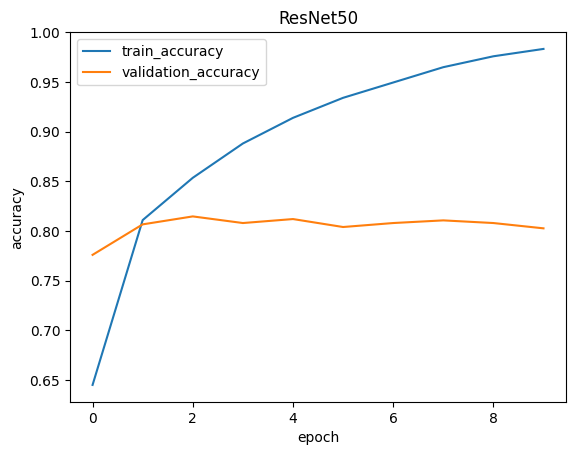

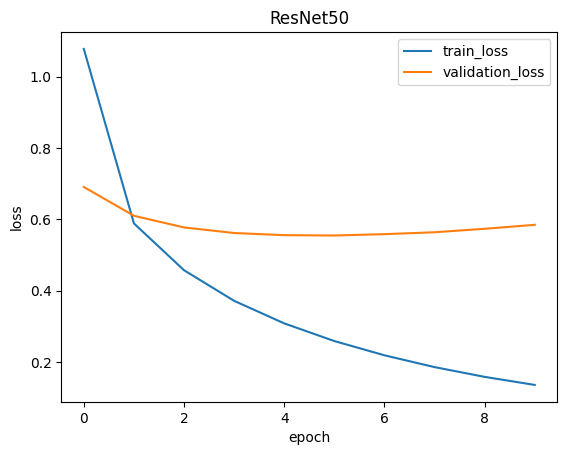

In [ ]:
#ResNet50 accuracy graph
plt.title("ResNet50")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

#ResNet50 loss graph
plt.title("ResNet50")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

### **Confusion Matrix**

We created a confusion matrix to understand how the true label corresponded to the predicted label. Having this confusion matrix gave us a better sense of how ResNet-50 was actually performing with our data.

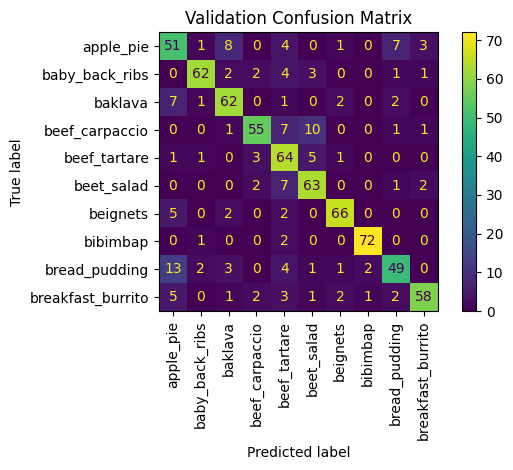

In [ ]:
#selected classes for confusion matrix
selected_classes = ["apple_pie","baby_back_ribs","baklava", "beef_carpaccio",
"beef_tartare","beet_salad", "beignets", "bibimbap", "bread_pudding",
"breakfast_burrito"]

val_ds = val_tfds.batch(BATCH_SIZE)
#processing model outputs into model predictions and the true values
y_true_list = []
y_pred_list = []
for x_batch, y_batch in val_ds:
  y_prob = model.predict(x_batch, verbose=0)
  y_pred = np.argmax(y_prob, axis=1)
  y_true_list.append(y_batch.numpy())
  y_pred_list.append(y_pred)
#concatenate data into counts for each class and produce confusion matrix
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
cm = confusion_matrix(y_true, y_pred)
#display matrix
class_names = selected_classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(xticks_rotation='vertical')
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()



### **MobileNetV2 model**

### **Preprocessing**

We have to preprocess the data again so it is compatible with MobileNetV2.

In [ ]:
IMG_SIZE = 224

def preprocess(example):
    #Obtain the image from the example
    image = example["image"]
    #Convert to RGB so it has 3 dimensions
    image = image.convert('RGB')
    #Resize to be by 224
    image = image.resize((IMG_SIZE, IMG_SIZE))
    #Obtain the image as a numpy array
    image = np.array(image)
    #Preprocess using the model's built-in preprocessing system
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    label = example["label"]
    return image, label

In [ ]:
#Used tf.data.Dataset from a generator to handle preprocessing for each of the
#images and then convert to correct output shape and type
#This source explains the generator: https://medium.com/the-owl/creating-a-tf-dataset-using-a-data-generator-5e5564609e64
train_tfds = tf.data.Dataset.from_generator(
    #We preprocess each part of the dataset
    lambda: (preprocess(x) for x in train_final),
    #The image itself is of type float and the label is of type int
    output_types=(tf.float32, tf.int64),
    #This corresponds to the 224 x 224 x 3 shape required for our model
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

val_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in val_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

test_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in test_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

### **Build the Model**

In [ ]:
#Load the base model
base_model = MobileNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [ ]:
BATCH_SIZE = 64

#Fit the model
history = model.fit(
    train_tfds.batch(BATCH_SIZE),
    epochs=10,
    validation_data=val_tfds.batch(BATCH_SIZE)
)

Epoch 1/10
    106/Unknown 72s 510ms/step - accuracy: 0.4997 - loss: 1.5274

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 92s 704ms/step - accuracy: 0.5010 - loss: 1.5238 - val_accuracy: 0.7427 - val_loss: 0.7678
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 447ms/step - accuracy: 0.7764 - loss: 0.6984 - val_accuracy: 0.7720 - val_loss: 0.6825
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 462ms/step - accuracy: 0.8162 - loss: 0.5718 - val_accuracy: 0.7813 - val_loss: 0.6525
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8487 - loss: 0.4934 - val_accuracy: 0.7840 - val_loss: 0.6377
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - accuracy: 0.8705 - loss: 0.4336 - val_accuracy: 0.7813 - val_loss: 0.6304
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - accuracy: 0.8909 - loss: 0.3845 - val_accuracy: 0.7840 - val_loss: 0.6260
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.9081 - loss: 0.3428 - val_accuracy: 0.7827 - val_loss: 0.6235
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 442ms/step - accuracy: 0.9191 - loss: 0.3068 - val

In [ ]:
#Evaluate the model
test_loss, test_acc = model.evaluate(val_tfds.batch(BATCH_SIZE))
print(f"\nMobileNetV2 Validation Accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - accuracy: 0.8142 - loss: 0.5976

MobileNetV2 Validation Accuracy: 0.7893


### **Plot the Data**

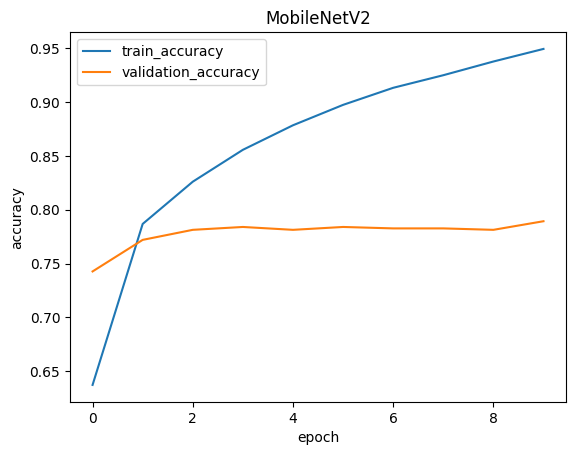

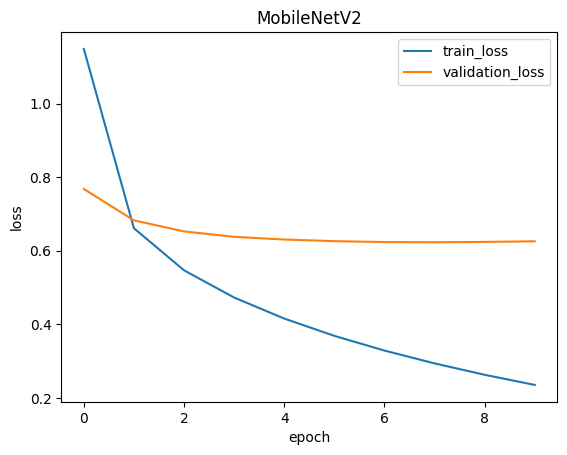

In [ ]:
#MobileNetV2 accuracy graph
plt.title("MobileNetV2")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

#MobileNetV2 loss graph
plt.title("MobileNetV2")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

### **EfficientNetB0 model**

### **Preprocessing**

We have to preprocess the data again so it is compatible with EfficientNetBO.

In [ ]:
IMG_SIZE = 224

def preprocess(example):
    #Obtain the image from the example
    image = example["image"]
    #Convert to RGB so it has 3 dimensions
    image = image.convert('RGB')
    #Resize to be by 224
    image = image.resize((IMG_SIZE, IMG_SIZE))
    #Obtain the image as a numpy array
    image = np.array(image)
    #Preprocess using the model's built-in preprocessing system
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    label = example["label"]
    return image, label

In [ ]:
#Used tf.data.Dataset from a generator to handle preprocessing for each of the
#images and then convert to correct output shape and type
#This source explains the generator: https://medium.com/the-owl/creating-a-tf-dataset-using-a-data-generator-5e5564609e64
train_tfds = tf.data.Dataset.from_generator(
    #We preprocess each part of the dataset
    lambda: (preprocess(x) for x in train_final),
    #The image itself is of type float and the label is of type int
    output_types=(tf.float32, tf.int64),
    #This corresponds to the 224 x 224 x 3 shape required for our model
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

val_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in val_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

test_tfds = tf.data.Dataset.from_generator(
    lambda: (preprocess(x) for x in test_final),
    output_types=(tf.float32, tf.int64),
    output_shapes=([IMG_SIZE, IMG_SIZE, 3], [])
)

In [ ]:
#Load the base model
base_model = EfficientNetB0(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3)
                            )

# Freeze pretrained weights
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [ ]:
BATCH_SIZE = 64

#Fit the model
history = model.fit(
    train_tfds.batch(BATCH_SIZE),
    epochs=10,
    validation_data=val_tfds.batch(BATCH_SIZE)
)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 100s 720ms/step - accuracy: 0.5238 - loss: 1.6238 - val_accuracy: 0.7933 - val_loss: 0.7145
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 464ms/step - accuracy: 0.7931 - loss: 0.6913 - val_accuracy: 0.8200 - val_loss: 0.5709
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - accuracy: 0.8161 - loss: 0.5602 - val_accuracy: 0.8280 - val_loss: 0.5270
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - accuracy: 0.8389 - loss: 0.4869 - val_accuracy: 0.8240 - val_loss: 0.5052
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - accuracy: 0.8656 - loss: 0.4344 - val_accuracy: 0.8307 - val_loss: 0.4915
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 451ms/step - accuracy: 0.8755 - loss: 0.3992 - val_accuracy: 0.8347 - val_loss: 0.4832
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - accuracy: 0.8955 - loss: 0.3543 - val_accuracy: 0.8373 - val_loss: 0.4792
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 449ms/step - accuracy: 0.9013 - loss: 

In [ ]:
#Evaluate the model
test_loss, test_acc = model.evaluate(val_tfds.batch(BATCH_SIZE))
print(f"\nEfficientNetB0 Validation Accuracy: {test_acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8569 - loss: 0.4356

EfficientNetB0 Validation Accuracy: 0.8360


### **Plot the Data**

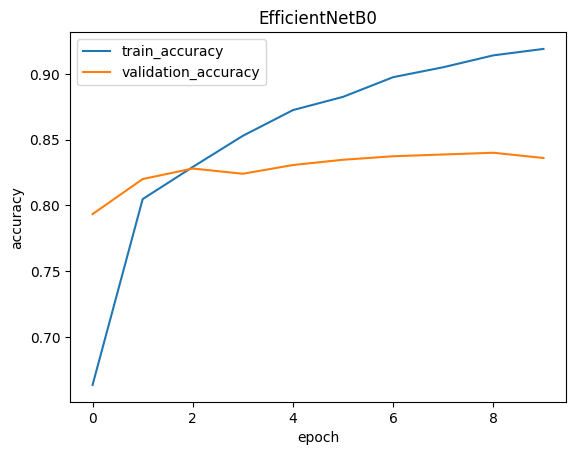

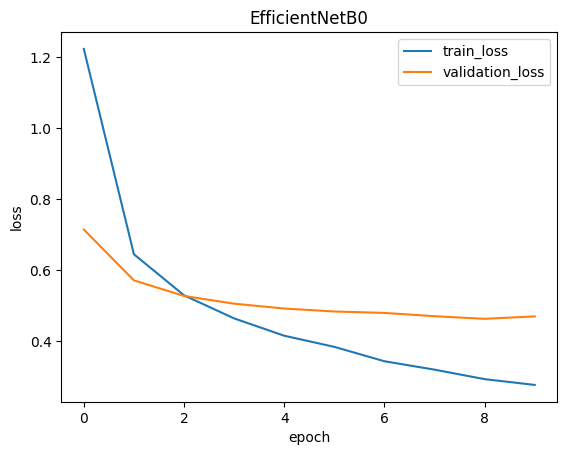

In [ ]:
#EfficientNetB0 accuracy graph
plt.title("EfficientNetB0")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

#EfficientNetB0 loss graph
plt.title("EfficientNetB0")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

## **Food101 ResNet50 Classifier**

The following blog from Steve Waite suggested that the food101 dataset is loaded using tTensorFlow datasets: https://stevewaite.github.io/TF-dev-cert/07_food_vision_milestone_project_1/

According to this article: https://lemon.io/answers/tensorflow/what-are-tensorflow-datasets/, "TFDS allows for efficient handling of data by loading, shuffling, and batching of datasets directly in TensorFlow pipelines. This saves memory and ensures better performance during model training."

We ran found that Google Colab runs out of RAM when we worked with the entire dataset loaded from Hugging Face.
However, we loaded with Hugging Face initially because making our dataset smaller after loading it from TensorFlow proved challenging due to formatting issues.

### **Preprocessing**

We consulted Steve Waite's blog for the following data split, but added validation data to enhance the statistical rigor of our pipeline. Week 4's assignment specifically encouraged us to do so. We did not do stratified split here since doing so with such a large dataset could have caused issues with RAM, but we did shuffle the dataset and since there are so many issues, this should suffice.

In [ ]:
#Adapted from Steve Waite's Blog

(train_data, test_data), ds_info = tfds.load(name="food101", #target dataset to get from TFDS
                                             split=["train", "validation"], #data splits
                                             shuffle_files=True, #shuffle files
                                             as_supervised=True, #download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) #include dataset metadata so tfds.load() returns tuple (data, ds_info)

#Create train/validation split out of original train
raw_train = train_data #Get raw training data

train_size = int(0.9 * 75750) #Size of training data

#Skipping certain sections of data
train_data = raw_train.take(train_size)
val_data = raw_train.skip(train_size)

In [ ]:
#Adapted from Steve Waite's Blog
IMG_SIZE = 224

def preprocess_img(image, label):
    # Resize to 224x224
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Apply ResNet50 preprocessing
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [ ]:
#Adapted from Steve Waite's Blog

train_data = (
    train_data
    #tf.data.AUTOTUNE parallels preprocessing and improves speed when calling preprocess_img
    .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    #Lowering the batch size allows us to run our model
    .batch(10)
    #randomly shuffles the elements
    #the buffer_size is not equal to the size of the dataset due to memory issues
    .shuffle(1000)
    #prepares other batches of data while some are computed on
    .prefetch(tf.data.AUTOTUNE)
)

val_data = (
    val_data
    .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

test_data = (
    test_data
    .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
#Inspect dataset
print(train_data)
print(val_data)
print(test_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### **Building the Model**

Note: Due to Google Colab restrictions on GPU usage, we could only run 5 epochs before RAM expired. However, doing a limited number of epochs could have helped mitigate excessive overfitting as opposed to running on too many epochs.

In [ ]:
#Load the base model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

In [ ]:
#Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    #Extra layer we added
    Dense(512, activation='relu'),
    Dense(101, activation='softmax')
])


In [ ]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=[
        'accuracy'])

In [ ]:
history = model.fit(train_data, epochs=7, validation_data=val_data)

Epoch 1/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 446s 58ms/step - accuracy: 0.3896 - loss: 2.5826 - val_accuracy: 0.5844 - val_loss: 1.6073
Epoch 2/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 387s 53ms/step - accuracy: 0.6199 - loss: 1.4537 - val_accuracy: 0.6422 - val_loss: 1.3735
Epoch 3/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 450s 54ms/step - accuracy: 0.6863 - loss: 1.1615 - val_accuracy: 0.6851 - val_loss: 1.1960
Epoch 4/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 383s 52ms/step - accuracy: 0.7410 - loss: 0.9427 - val_accuracy: 0.7258 - val_loss: 1.0213
Epoch 5/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 425s 58ms/step - accuracy: 0.7920 - loss: 0.7613 - val_accuracy: 0.7596 - val_loss: 0.8967
Epoch 6/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 389s 53ms/step - accuracy: 0.8387 - loss: 0.5886 - val_accuracy: 0.7839 - val_loss: 0.7813
Epoch 7/7
6818/6818 ━━━━━━━━━━━━━━━━━━━━ 386s 53ms/step - accuracy: 0.8770 - loss: 0.4509 - val_accuracy: 0.7831 - val_loss: 0.7820


In [ ]:
#Evaluate the model
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.6701385974884033


### **Plot the Data**

It's notable that our model did not obtain the validation loss data we wanted it to, even though we incorporated validation data during model fitting. However, we did plot training accuracy and training loss below. As we mentioned above, after running through multiple GPUs on multiple different gmail accounts we created for the purposes of Google Colab, we had to accept our results.

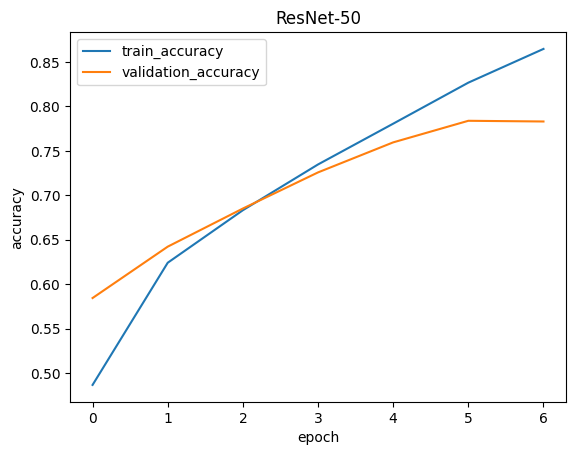

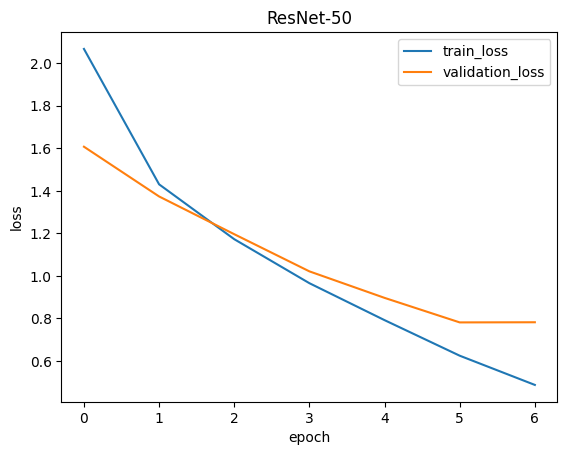

In [ ]:
#ResNet-50 accuracy graph
plt.title("ResNet-50")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

#ResNet-50 loss graph
plt.title("ResNet-50")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()